In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [2]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
print(len(train_df))
train_df.head()

42000


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/tmp/ipykernel_36/1730181610.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0]


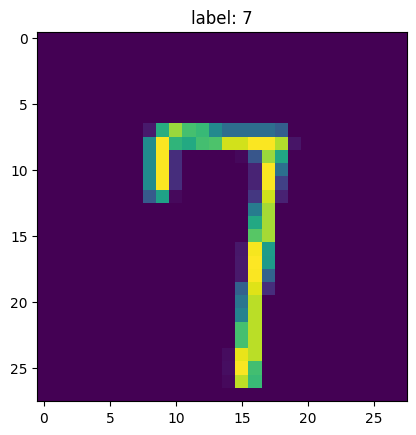

In [3]:
row = train_df.iloc[50]
label = row[0]
image = np.array(row[1:]).reshape(28,28)
image = 2*(image/255)-1
plt.imshow(image)
plt.title(f'label: {label}')
plt.show()

In [4]:
class MnistDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = row[0]
        image = torch.tensor(row[1:]).reshape(1, 28,28)
        image = 2*(image/255)-1
        return image, torch.as_tensor(label)
        

/tmp/ipykernel_36/1660039328.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0]
/tmp/ipykernel_36/1660039328.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = torch.tensor(row[1:]).reshape(1, 28,28)


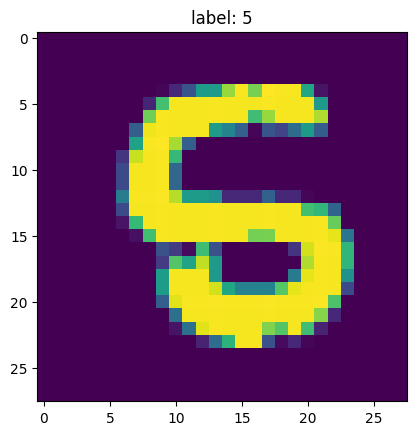

In [5]:
train_dataset = MnistDataset(train_df)
image, label = train_dataset[19]
plt.imshow(image.squeeze(0))
plt.title(f'label: {label}')
plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class VAEModel(nn.Module):
    def __init__(self):
        super(VAEModel, self).__init__()

        self.common_fc = nn.Sequential(
            nn.Linear(28*28, 196),
            nn.Tanh(),
            nn.Linear(196, 48),
            nn.Tanh()
        )

        self.mean_fc = nn.Sequential(
            nn.Linear(48, 16),
            nn.Tanh(),
            nn.Linear(16, 2),
            nn.Tanh()
        )

        self.log_var_fc = nn.Sequential(
            nn.Linear(48, 16),
            nn.Tanh(),
            nn.Linear(16, 2),
            nn.Tanh()
        )

        self.decoder_fc = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16, 48),
            nn.Tanh(),
            nn.Linear(48, 196),
            nn.Tanh(),
            nn.Linear(196, 28*28),
            nn.Tanh(),
        )

    def forward(self, x):
        # x -> B,C,H,W
        ## Encoder part
        mean, log_var = self.encode(x)
        ## Sampling part
        z = self.sample(mean, log_var)
        ## Decoder part
        out = self.decode(z)
        return mean, log_var, out

    def encode(self, x):
        out = self.common_fc(torch.flatten(x, start_dim=1))
        mean = self.mean_fc(out)
        log_var = self.log_var_fc(out)
        return mean, log_var

    def sample(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std)
        z = z * std + mean
        return z

    def decode(self, z):
        out = self.decoder_fc(z)
        out = out.reshape(z.shape[0], 1, 28, 28)
        return out
        

In [24]:
model = VAEModel().to(device)

def train_vae():
    # dataset and Data Loader
    mnist_train = MnistDataset(train_df)
    mnist_test = MnistDataset(test_df)
    mnist_loader = DataLoader(mnist_train, batch_size = 64, shuffle=True, num_workers=0)

    #Training params
    num_epochs = 10
    optimizer = optim.Adam(model.parameters(), lr=1E-3)
    criterian = torch.nn.MSELoss()

    reconstruction_losses = []
    kl_losses = []
    total_losses = []

    # training
    for epoch_idx in range(num_epochs):
        for im, label in tqdm(mnist_loader):
            im = im.float().to(device)
            optimizer.zero_grad()

            mean, log_var, reconstructed_image = model(im)
            reconstruction_loss = criterian(im, reconstructed_image)
            kl_loss = torch.mean(0.5 * torch.sum(torch.exp(log_var) + mean**2 -1 -log_var, dim=-1))
            loss = reconstruction_loss + 1E-5 * kl_loss
            reconstruction_losses.append(reconstruction_loss.item())
            kl_losses.append(kl_loss.item())
            total_losses.append(loss.item())

            loss.backward()
            optimizer.step()
        print('Finished epoch: {} | Recon Loss: {:.4f} | KL Loss: {:.4f}'.format(
            epoch_idx+1,
            np.mean(reconstruction_losses),
            np.mean(kl_losses)
        ))

    print('Training completed!!!!')    

In [ ]:
train_vae()

  0%|          | 0/657 [00:00<?, ?it/s]/tmp/ipykernel_36/1660039328.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0]
/tmp/ipykernel_36/1660039328.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = torch.tensor(row[1:]).reshape(1, 28,28)
  3%|▎         | 20/657 [00:07<04:06,  2.58it/s]

/tmp/ipykernel_36/245016102.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_img = torch.Tensor(test_df.iloc[pos][0:]).reshape(1, 28, 28).float().to(device)


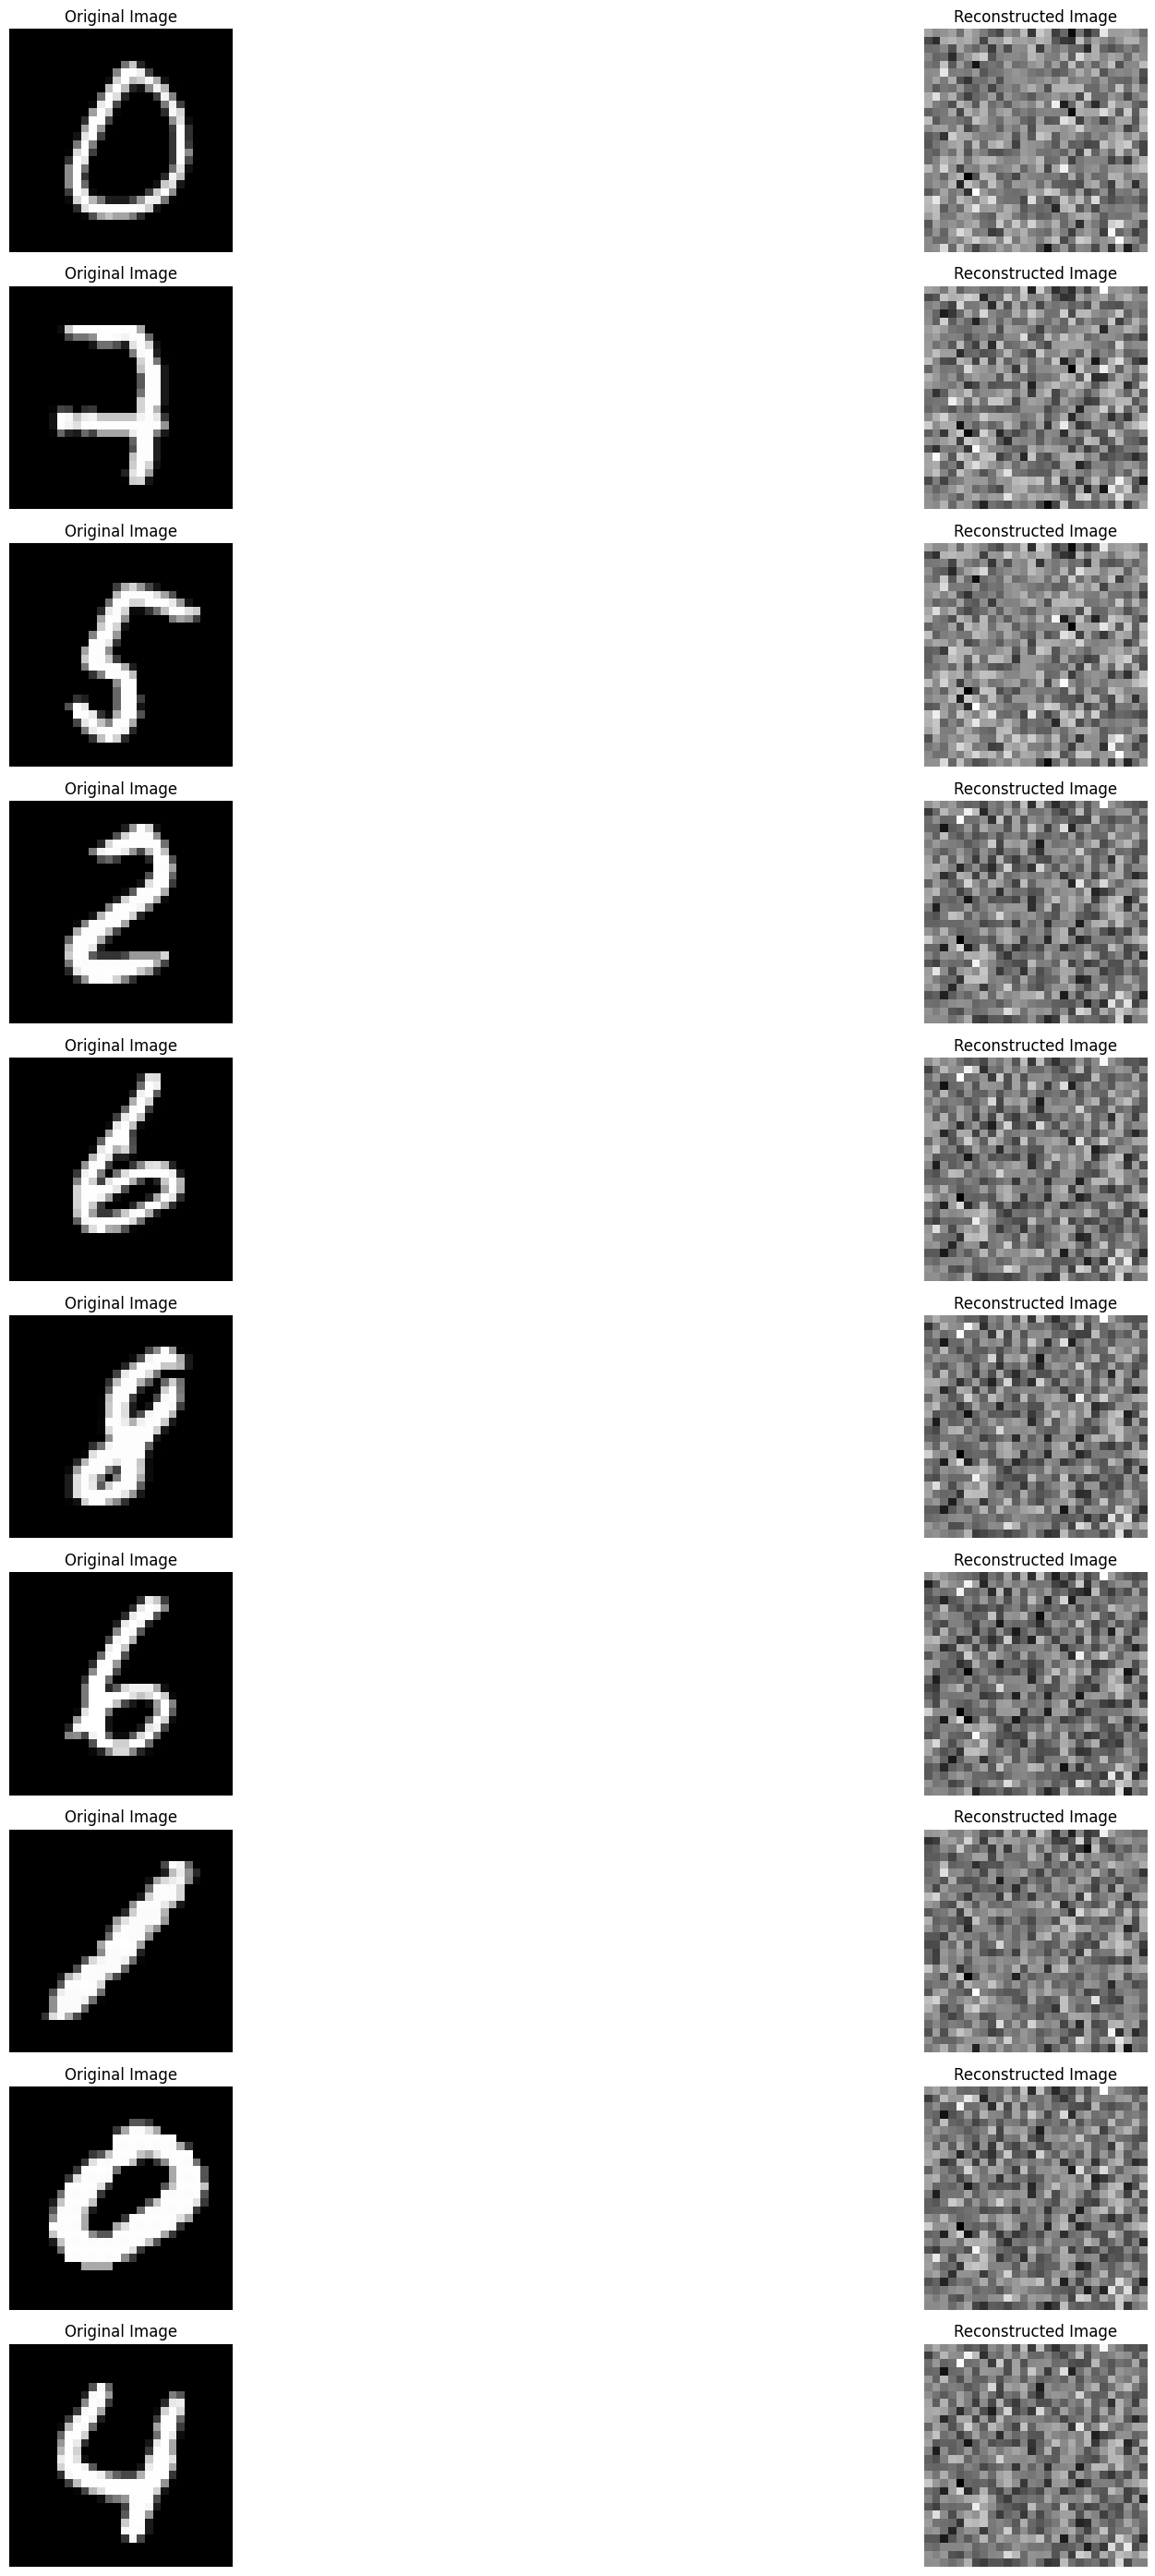

In [23]:
# validation
indices = torch.randint(0, len(test_df)-1, (10,))
fig, axes = plt.subplots(10, 2, figsize=(28, 28))
        
for idx in range(len(indices)):
        pos = indices[idx].item()
        input_img = torch.Tensor(test_df.iloc[pos][0:]).reshape(1, 28, 28).float().to(device)
        _, _, gen_image = model(input_img)
        gen_image = gen_image.detach().cpu().numpy().squeeze()
            
        # Plot the Original Image on the first subplot (axes[0])
        axes[idx][0].imshow(input_img.cpu().squeeze(), cmap='gray')
        axes[idx][0].set_title("Original Image")
        axes[idx][0].axis('off')  # Hide the axes ticks
            
        # Plot the Reconstructed Image on the second subplot (axes[1])
        axes[idx][1].imshow(gen_image, cmap='gray')
        axes[idx][1].set_title("Reconstructed Image")
        axes[idx][1].axis('off')  # Hide the axes ticks
        
    # Adjust layout to prevent titles from overlapping
plt.tight_layout()
        
    # Save the figure to a file
plt.savefig("original_vs_reconstructed.png")
    